# Binomial Tree
The binomial tree method was pioneered by Cox, Ross, and Robinstein in 1979. The binomial model allows the stock to move up or down a specific amount over the next time step. Given the initial stock price $S$, we allow it to either go up or down by a factor $\mathrm{u}$ and $\mathrm{v}$ resulting in the value $u S$ and $v S$ after the next time step. Extending this random walk after two time steps, the asset will either be at $u^{2} S$, if there are two up moves or at $v^{2} S$ if there are two down moves or at $u v S$ if an up was followed by a down move or vice versa. We can extend this to any number of time step (or branches) depending on how complex you want the model to be or until expiration.

This structure where nodes represent the values taken by the asset is called the binomial tree.

## 1.1 Load Libraries

In [4]:
import numpy as np

# Import plotting functions from helper.py
from helper import plot_asset_path, binomial_grid, plot_binomial_tree, plot_probability


## 1.2 Price Path
The probability of reaching a particular node in the binomial tree depends on the numbers of distinct paths to that node and the probabilities of the up and down moves. The following figures shows the number of paths to each node and the probability of reaching to that node.

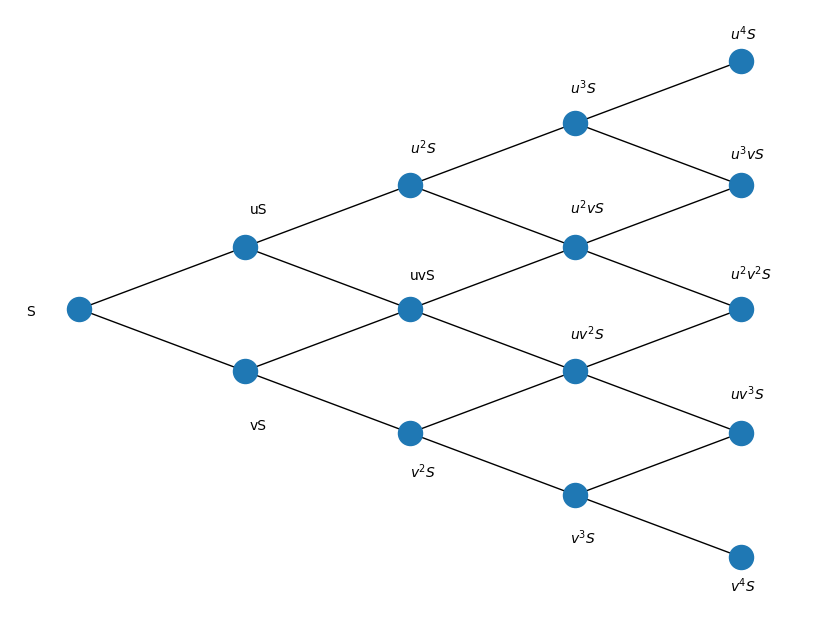

In [2]:
# Plot the asset price path
plot_asset_path()

## 1.3 Path Probability

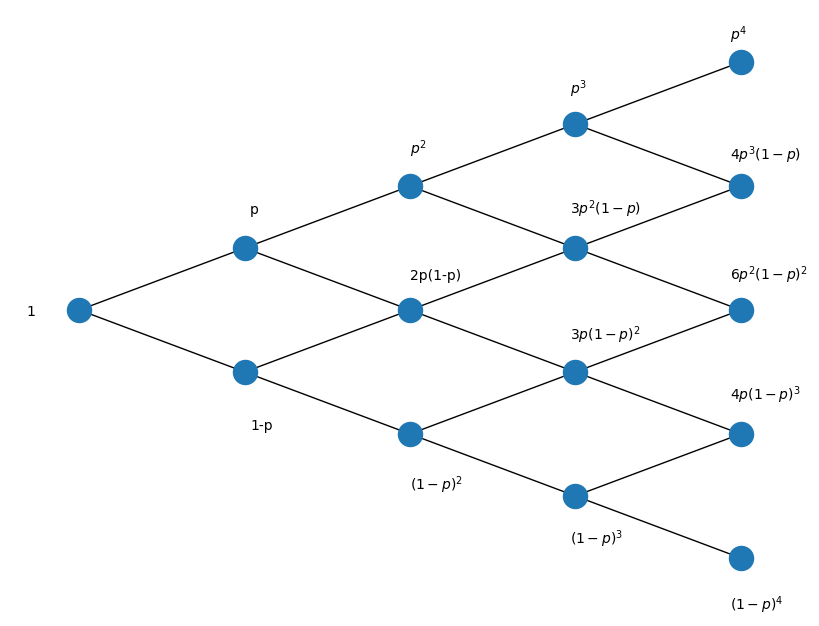

In [5]:
# Plot the node probabilities
plot_probability()

## 1.4 Risk Neutral Probability
Risk-neutral measure is a probability measure such that each share price today is the discounted expectations of the share price. We know the formula for $u, v, p^{\prime}$ and $V$ are as follows,

$$
\begin{aligned}
& u=1+\{\sigma \sqrt{\delta t}\} \\
& v=1-\{\sigma \sqrt{\delta t}\}
\end{aligned}
$$

The underlying instrument will move up or down by a specific factor $u$ or $v$ per step of the tree where $u \geq 1$ and $0<v \leq 1$.

$$
p^{\prime}=\frac{1}{2}+\frac{r \sqrt{\delta} t}{2 \sigma}
$$

where, $p^{\prime}$ the risk-neutral probability.

$$
V=\frac{1}{1+r \delta t}\left(p^{\prime} V^{+}+\left(1-p^{\prime}\right) V^{-}\right)
$$

where, $V$ is the option value which is the present value of some expectation : sum probabilities multiplied by events.

## 1.5 Building the Binomial Tree
Next, we will build a binomial tree using the risk neutral probability. Building a tree is a multi step process which involves.

Step 1: Draw a n-step tree

Step 2: At the end of n-step, estimate terminal prices

Step 3: Calculate the option value at each node based on the terminal price, exercise price and type

Step 4: Discount it back one step, that is, from $\mathrm{n}$ to $\mathrm{n}-1$, according to the risk neutral probability

Step 5: Repeat the previous step until we find the final value at step 0

## 1.6 Binomial Pricing Model
Now we define a binomial option pricing function

In [8]:
# Create a binomial option pricing function
def binomial_option(spot, strike, rate, sigma, time, steps, output=0):
    '''
    binomial_option(spot, strike, rate, sigma, time, steps, output=0)
    Function for building binomial option tree for european call option payoff
    Args:
        spot: int or float - spot price
        strike: int or float - strike price
        rate: float - interest rate
        sigma: float - volatility
        time: int or float - expiration time
        steps: int - number of trees
        output: int - [0: price, 1: payoff, 2: option value, 3: option delta]
    Returns:
        out: ndarray - An array object of price, payoff, option value and delta specified by the output parameter
    '''

    # Parameters
    ts = time / steps
    u = 1 + sigma * np.sqrt(ts)
    v = 1 - sigma * np.sqrt(ts)
    p = 0.5 + rate*np.sqrt(ts) / 2 * sigma
    df = 1 / (1+ rate * ts)

    # Initialise empty arrays
    px = np.zeros((steps+1, steps+1))
    cp = np.zeros((steps+1, steps+1))
    V = np.zeros((steps+1, steps+1))
    d = np.zeros((steps+1, steps+1))

    # Binomial loop made up of two loops

    # First loop: Forward loop
    for j in range(steps + 1):
        for i in range(j + 1):
            px[i, j] = spot * np.power(v, i) * np.power(u, j - i)
            cp[i, j] = np.maximum(px[i, j] - strike, 0)

    # Second loop: Reverse loop
    for j in range(steps+1, 0, -1):
        for i in range(j):
            if j == steps + 1:
                V[i, j-1] = cp[i, j-1]
                d[i, j-1] = 0 # Option has expired
            else:
                V[i, j-1] = df * (p * V[i, j] + (1-p) * V[i+1, j])
                d[i, j-1] = (V[i, j] - V[i+1, j]) / (px[i, j] - px[i+1, j])
    
    results = np.around(px, 2), np.around(cp, 2), np.around(V, 2), np.around(d, 4)
    return results[output]

In [18]:
# Asset price
px = binomial_option(100, 100, 0.05, 0.2, 1, 4, 0)
px

array([[100.  , 110.  , 121.  , 133.1 , 146.41],
       [  0.  ,  90.  ,  99.  , 108.9 , 119.79],
       [  0.  ,   0.  ,  81.  ,  89.1 ,  98.01],
       [  0.  ,   0.  ,   0.  ,  72.9 ,  80.19],
       [  0.  ,   0.  ,   0.  ,   0.  ,  65.61]])

In [19]:
# Intrinsic value of call options
cp = binomial_option(100, 100, 0.05, 0.2, 1, 4, 1)
cp

array([[ 0.  , 10.  , 21.  , 33.1 , 46.41],
       [ 0.  ,  0.  ,  0.  ,  8.9 , 19.79],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [20]:
# Option price
opx = binomial_option(100, 100, 0.05, 0.2, 1, 4, 2)
opx

array([[ 7.57, 12.86, 21.08, 32.76, 46.41],
       [ 0.  ,  2.42,  4.87,  9.82, 19.79],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [12]:
# Option delta
d = binomial_option(100, 100, 0.05, 0.2, 1, 4, 3)
d

array([[0.522 , 0.7368, 0.9477, 1.    , 0.    ],
       [0.    , 0.2708, 0.496 , 0.9086, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

In [17]:
# Binomial Option Price
print(f'European Call Option Price using Binomial Tree: {opx[0, 0]:.2f}')

European Call Option Price using Binomial Tree: 7.57


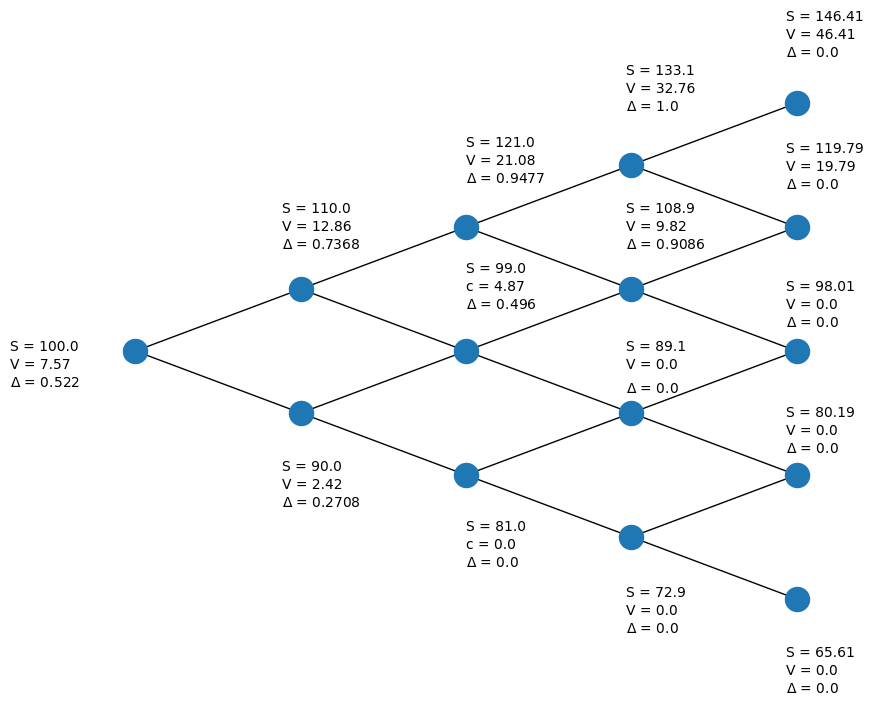

: 

In [21]:
# Plot a 4-step Binomial Tree
plot_binomial_tree(px[0, 0], px, opx, d)